Text(0.5, 1.0, 'Daily new infections, ACT')

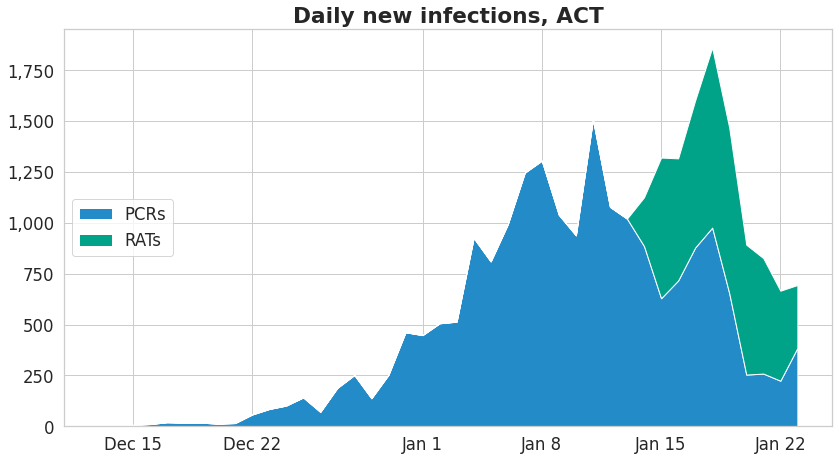

In [47]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, matplotlib.ticker as ticker, matplotlib.dates as mdates
sns.set(font_scale=1.5, style="whitegrid")

data = pd.read_csv("./caseData.csv", parse_dates=["date"])
data = data[data.date > data.iat[len(data)-1, 0] - pd.Timedelta(days=42)]

fig, ax = plt.subplots(
    figsize=(12, 6.75),
    tight_layout=True
)
plt.stackplot(data.date, data.pcr, data.rat, colors=["#248BC9", "#00A388"])
plt.legend(["PCRs", "RATs"], loc="center left")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %-d"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
plt.title("Daily new infections, ACT", size="large", fontweight="bold")